# Classification (MultiClass) using SVM & Optimal Parameter Selection

This notebook is intended for beginners to provide them a guideline for where to start using Simple Classifier  **SVM**. 

**Level :** Beginner <br>

**Task :** To classify digits from 0 to 9 using [MNIST Handdrawn Digits Image Datatset](https://www.kaggle.com/c/digit-recognizer).

**About Data: **
Data contains images of hand-drawn digits, from zero through nine. 

Image Details : Gray Scale , 28x28 pixel ,pixel value - 0(lightest) to 255(darkest)

### Notebook Content 
1. [Exploring and Preparing Data](#explore)
2. [Support Vector Machine (SVM)](#svm)
3. [Classifcation Using SVM](#clf_svm) 
 *    [ Case1 - GrayScale Images](#case1)
 *    [Case2 - Binary Images](#case2)
 *    [Case3 - GrayScale + Reduced Dimensions(using PCA)](#case3)
 *    [Case4 - Binary + Reduced Dimensions(using PCA)](#case4)
 *    [Comparison of Four Cases](#cases) 
4.  [Training Data Size Vs Accuracy, Score & Fitting Time](#compare)
5. [Parameter Selection for SVM Using GridSearchCV](#param)
6. [Submission](#sub)


Importing required libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt, matplotlib.image as mpimg
import time 
import warnings
from sklearn import svm
from sklearn.model_selection import GridSearchCV

%matplotlib inline
warnings.filterwarnings('ignore')

print(os.listdir("./data"))

['sample_submission.csv', 'test.csv', 'train.csv']


  ## <a id="explore">1. Exploring and Preparing Data</a>
<br>
Reading data from "train.csv", which will later be divided into train(to train model) and test(to check accuracy).  

In [4]:
data = pd.read_csv('./data/train.csv')
print("Train Data Shape is: ",data.shape)
data.head()

Train Data Shape is:  (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Extracting label from data

In [5]:
label = data.label
data=data.drop('label',axis=1)
print("Data Shape: ",data.shape)
print("Label Shape: ",label.shape)

Data Shape:  (42000, 784)
Label Shape:  (42000,)


In [6]:
data.columns

Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)

Converting 1D array to 2D 28x28 array using [**reshape**](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html) , to plot and view grayscale images. 

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


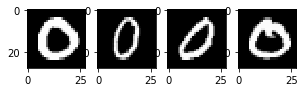

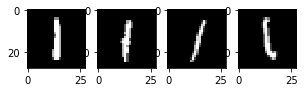

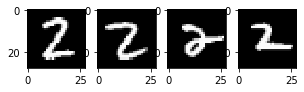

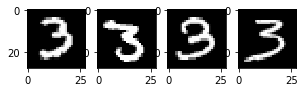

In [7]:
for x in range(0,4):
    train_0=data[label==x]
    data_new=[]
    for idx in train_0.index:
        val=train_0.loc[idx].values.reshape(28,28)
        data_new.append(val)
    plt.figure(figsize=(25,25))   
    for x in range(1,5):
        ax1=plt.subplot(1, 20, x)
        ax1.imshow(data_new[x],cmap='gray')

Having a look at pixel values frequency (0 to 255)<br>
To get a better idea, lets convert the plot to Log Scale.<br>
Based on leading 0s and 255s we can try converting it to binary in the later steps to simplify the problem.

Text(0, 0.5, 'Frequency')

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


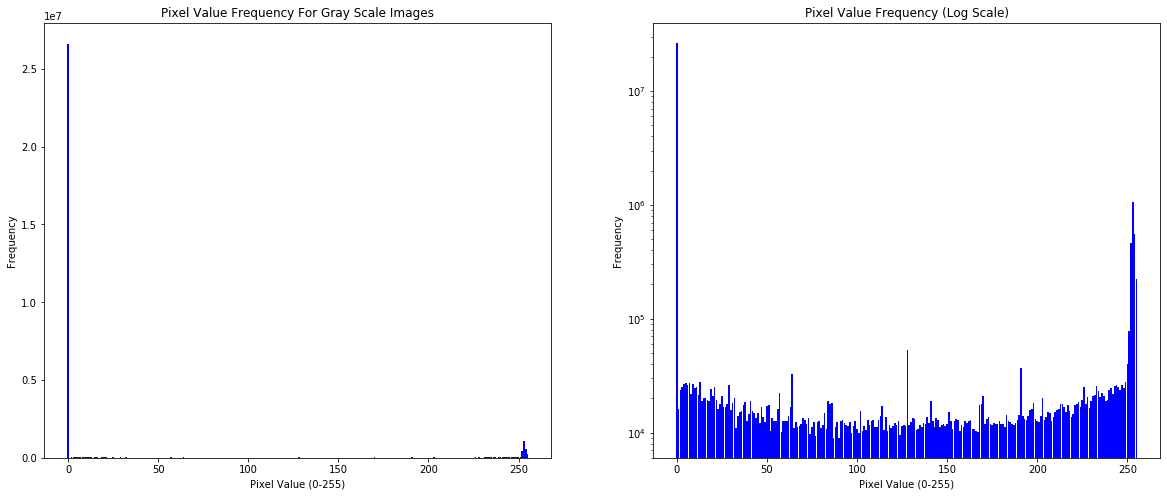

In [8]:
y = pd.value_counts(data.values.ravel()).sort_index()
N = len(y)
x = range(N)
width =0.9
plt.figure(figsize=[20,8])
ax1=plt.subplot(1, 2,1)
ax1.bar(x, y, width, color="blue")
plt.title('Pixel Value Frequency For Gray Scale Images')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')
#ax1.imshow(data_new[x],cmap='gray')
ax2=plt.subplot(1, 2,2)
ax2.bar(x, y, width, color="blue")
plt.title('Pixel Value Frequency (Log Scale)')
plt.yscale('log')
plt.xlabel('Pixel Value (0-255)')
plt.ylabel('Frequency')
#plt.yscale('')

### Splitting data into Train and Test Data and Labels
<br>

Dividing Data randomly into **train** and **test**. Out of total **train.csv** Data, 80% is kept as train for training the model and 20% is kept as test to score the model. 

In [9]:
train, test,train_labels, test_labels = train_test_split(data, label, train_size=0.8, random_state=42)
print("Train Data Shape: ",train.shape)
print("Train Label Shape: ",train_labels.shape)
print("Test Data Shape: ",test.shape)
print("Test Label Shape: ",test_labels.shape)

Train Data Shape:  (33600, 784)
Train Label Shape:  (33600,)
Test Data Shape:  (8400, 784)
Test Label Shape:  (8400,)


## <a id="svm"> 2. Support Vector Machine (SVM)<a>

> *<br>Support Vector Machine (SVM) is a supervised machine learning algorithm which can be used for both classification or regression problems.
> It performs classification by finding the hyperplane that maximizes the margin between the two classes.*

To understand better, lets look at the following cases:<br>

**CASE 1**: <br> 
Here, we have three hyper-planes (A, B and C). Now, identify the right hyper-plane to classify star and circle<br>
As per SVM: “Select the hyper-plane which segregates the two classes better”.<br>
Here better means which keeps almost equal margin/distance from both classes. <br>
**Answer : B**

![scenario1](https://github.com/SabaSiddiqi/Backup/blob/master/svm_scenario1.png?raw=true)


**CASE 2: **<br>
Here, we have three hyper-planes (A, B and C). To identify the right hyper-plane to classify star and circle,
Maximizing the distances between nearest data point (either class) and hyper-plane will help us to decide the right hyper-plane. 
This distance is called as Margin
**Answer : C**
![margin](https://github.com/SabaSiddiqi/Backup/blob/master/margin.png?raw=true)



## <a id="clf_svm">3. Classification using SVM<a>

Using [SVM Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) from sklearn library.<br>
We have 33600 training samples, fitting them is going to take alot of time. To keep it simple for now, lets select 5000 out of them.<br>
You can change the value i to use the desired number of samples.

In [10]:
i=5000;
score=[]
fittime=[]
scoretime=[]
clf = svm.SVC(random_state=42)

We are not passing parameters in this step to keep it simple and will be using the default ones.

In [11]:
print("Default Parameters are: \n",clf.get_params)

Default Parameters are: 
 <bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)>


### <a id="case1">Case 1 - Gray Scale Images</a>


Fitting train data and finding a score for test data to check model performance

In [12]:
start_time = time.time()
clf.fit(train[:i], train_labels[:i].values.ravel())
fittime = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fittime)))
start_time = time.time()
score=clf.score(test,test_labels)
print("Accuracy for grayscale: ",score)
scoretime = time.time() - start_time
print("Time consumed to score: ",time.strftime("%H:%M:%S", time.gmtime(scoretime)))
case1=[score,fittime,scoretime]

Time consumed to fit model:  00:00:54
Accuracy for grayscale:  0.09345238095238095
Time consumed to score:  00:00:45


### <a id="case2">Case 2 - Binary Images</a>
<br>
To simply the problem, converting images to black and white from gray scale by replacing all values > 0 to 1. 
<br>And Converting 1D array to 2D 28x28 array using [**reshape**](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.reshape.html) , to plot and view **binary** images. 

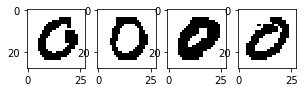

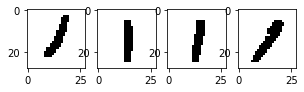

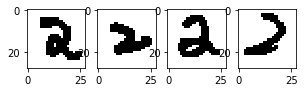

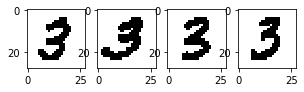

In [13]:
test_b=test
train_b=train
test_b[test_b>0]=1
train_b[train_b>0]=1
for x in range(0,4):
    train_0=train_b[train_labels==x]
    data_new=[]
    for idx in train_0.index:
        val=train_0.loc[idx].values.reshape(28,28)
        data_new.append(val)
    plt.figure(figsize=(25,25))   
    for x in range(1,5):
        ax1=plt.subplot(1, 20, x)
        ax1.imshow(data_new[x],cmap='binary')

In [14]:
start_time = time.time()
clf.fit(train_b[:i], train_labels[:i].values.ravel())
fititme = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fittime)))
score=clf.score(test_b,test_labels)
start_time = time.time()
clf.fit(train_b[:i], train_labels[:i].values.ravel())
print("Accuracy for binary: ",score)
scoretime = time.time() - start_time
print("Time consumed to score: ",time.strftime("%H:%M:%S", time.gmtime(scoretime)))
case2=[score,fittime,scoretime]

Time consumed to fit model:  00:00:54
Accuracy for binary:  0.9111904761904762
Time consumed to score:  00:00:11


It can be seen that for the chosen training samples, accuracy of Case 2 (~90%) is way higher than Case 1 (10%).

However, the high dimensionaly of data is making computational time high. Lets reduce the dimensions using PCA (Principal Component Analysis)

### <a id="case3">Case 3 - GrayScale + Dimensionality Reduction - PCA</a> <br>

 It is a linear transformation technique used to identify strong patterns in data by finding out variable correlation. It maps the data to a lower dimensional subspace in a way that data variance is maximized while retaining most of the information.
 
 To understand how PCA works, this tutorial may help - [Principal Component Analysis Explained](https://www.kaggle.com/sabasiddiqi/principal-component-analysis-explained)

We are using [sklearnPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) library here to perform PCA Dimensionality Reduction.

Here, Data is standardized and PCA is performed on data with all the components. Then variance is plotted for all components to decide which components to remove. 

Text(0, 0.5, 'Variance')

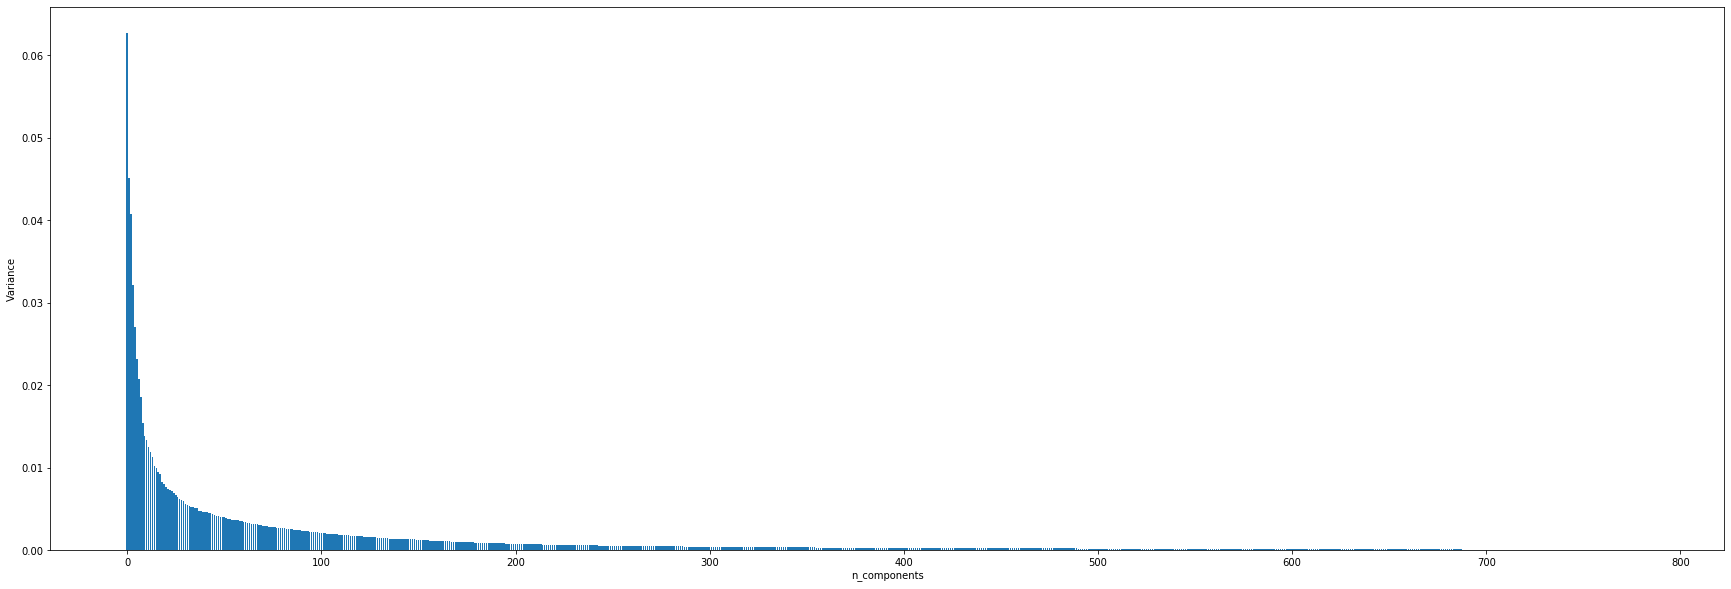

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

#standardized data
sc = StandardScaler().fit(train)
X_std_train = sc.transform(train)
X_std_test = sc.transform(test)

#If n_components is not set then all components are stored 
sklearn_pca = sklearnPCA().fit(X_std_train)
train_pca = sklearn_pca.transform(X_std_train)
test_pca = sklearn_pca.transform(X_std_test)

#Percentage of variance explained by each of the selected components.
#If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.
var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(30,10))
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xlabel('n_components')
plt.ylabel('Variance')

Keeping 90% of information by choosing components falling within 0.90 cumulative.

In [16]:
n_comp=len(cum_var_per[cum_var_per <= 0.90])
print("Keeping 90% Info with ",n_comp," components")
sklearn_pca = sklearnPCA(n_components=n_comp)
train_pca = sklearn_pca.fit_transform(X_std_train)
test_pca = sklearn_pca.transform(X_std_test)
print("Shape before PCA for Train: ",X_std_train.shape)
print("Shape after PCA for Train: ",train_pca.shape)
print("Shape before PCA for Test: ",X_std_test.shape)
print("Shape after PCA for Test: ",test_pca.shape)


Keeping 90% Info with  288  components
Shape before PCA for Train:  (33600, 784)
Shape after PCA for Train:  (33600, 288)
Shape before PCA for Test:  (8400, 784)
Shape after PCA for Test:  (8400, 288)


Lets find the score using reduced dimensions keeping the same amount of samples, to compare accuracy.

In [17]:
start_time = time.time()
clf.fit(train_pca[:i], train_labels[:i].values.ravel())
fittime = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fittime)))
start_time = time.time()
score=clf.score(test_pca,test_labels)
print("Accuracy for grayscale: ",score)
scoretime = time.time() - start_time
print("Time consumed to score model: ",time.strftime("%H:%M:%S", time.gmtime(scoretime)))
case3=[score,fittime,scoretime]

Time consumed to fit model:  00:00:07
Accuracy for grayscale:  0.9188095238095239
Time consumed to score model:  00:00:09


It can be seen that for the chosen training samples, accuracy of Case1 after PCA is (~91%) which was previously (10%).

### <a id="case4">Case 4 - Binary + Dimensionality Reduction - PCA</a> <br> 
<br>
Using the steps steps we used in Case 3.

Text(0, 0.5, 'Variance')

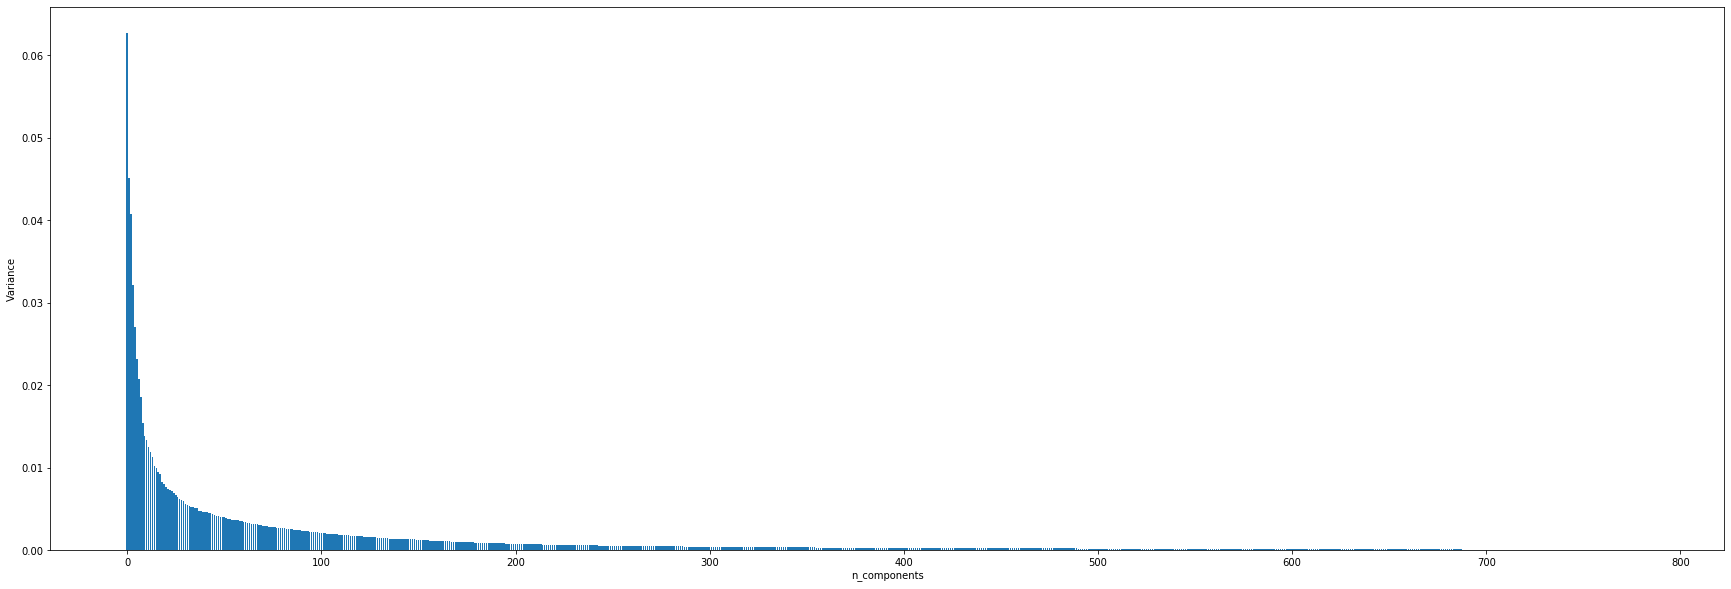

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA

#standardized data
sc = StandardScaler().fit(train_b)
X_std_train = sc.transform(train_b)
X_std_test = sc.transform(test_b)

#If n_components is not set then all components are stored 
sklearn_pca = sklearnPCA().fit(X_std_train)
#train_pca_b = sklearn_pca.transform(X_std_train)
#test_pca_b = sklearn_pca.transform(X_std_test)

#Percentage of variance explained by each of the selected components.
#If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.
var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(30,10))
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xlabel('n_components')
plt.ylabel('Variance')

In [19]:
n_comp=len(cum_var_per[cum_var_per <= 0.90])
print("Keeping 90% Info with ",n_comp," components")
sklearn_pca = sklearnPCA(n_components=n_comp)
train_pca_b = sklearn_pca.fit_transform(X_std_train)
test_pca_b = sklearn_pca.transform(X_std_test)
print("Shape before PCA for Train: ",X_std_train.shape)
print("Shape after PCA for Train: ",train_pca_b.shape)
print("Shape before PCA for Test: ",X_std_test.shape)
print("Shape after PCA for Test: ",test_pca_b.shape)

Keeping 90% Info with  288  components
Shape before PCA for Train:  (33600, 784)
Shape after PCA for Train:  (33600, 288)
Shape before PCA for Test:  (8400, 784)
Shape after PCA for Test:  (8400, 288)


In [20]:
start_time = time.time()
clf.fit(train_pca_b[:i], train_labels[:i].values.ravel())
fittime = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fittime)))
start_time = time.time()
score=clf.score(test_pca_b,test_labels)
print("Accuracy for grayscale: ",score)
scoretime = time.time() - start_time
print("Time consumed to score model: ",time.strftime("%H:%M:%S", time.gmtime(scoretime)))
case4=[score,fittime,scoretime]

Time consumed to fit model:  00:00:06
Accuracy for grayscale:  0.9185714285714286
Time consumed to score model:  00:00:09


### <a id="cases">Comparison of 4 Cases</a>

In [21]:
head =["Accuracy","FittingTime","ScoringTime"]
print("\t\t case1 \t\t\t case2 \t\t\t case3 \t\t\t case4")
for h, c1, c2, c3, c4 in zip(head, case1, case2, case3, case4):
    print("{}\t{}\t{}\t{}\t{}".format(h, c1, c2, c3, c4))

		 case1 			 case2 			 case3 			 case4
Accuracy	0.09345238095238095	0.9111904761904762	0.9188095238095239	0.9185714285714286
FittingTime	54.3865110874176	54.3865110874176	7.1078431606292725	6.590985298156738
ScoringTime	45.987287759780884	11.784906148910522	9.89167594909668	9.484734535217285


**Observations:**
*  By simplifying the problem in Case 2 (by converting images to binary), accuracy increases from ~10% to ~91% for the chosen number of samples.
* By reducing dimensions in Case3 and Case4, Fitting Times Reduces Drastically from ~43sec to ~6sec for the chosen number of samples.

 ## <a id="sizevsacc">4. Training Data Size Vs Accuracy , Fitting & Score Times </a>


<br>Understanding how training data size affects accuracy,

In [22]:
from tqdm import tqdm

fit_time=[]
score=[]
score_time=[]
for j in tqdm(range(1000,31000,5000)):
    start_time = time.time()
    clf.fit(train_pca_b[:j], train_labels[:j].values.ravel())
    fit_time.append(time.time() - start_time)
    start_time = time.time()
    score.append(clf.score(test_pca_b,test_labels))
    score_time.append(time.time() - start_time)

100%|██████████| 6/6 [07:35<00:00, 75.92s/it]


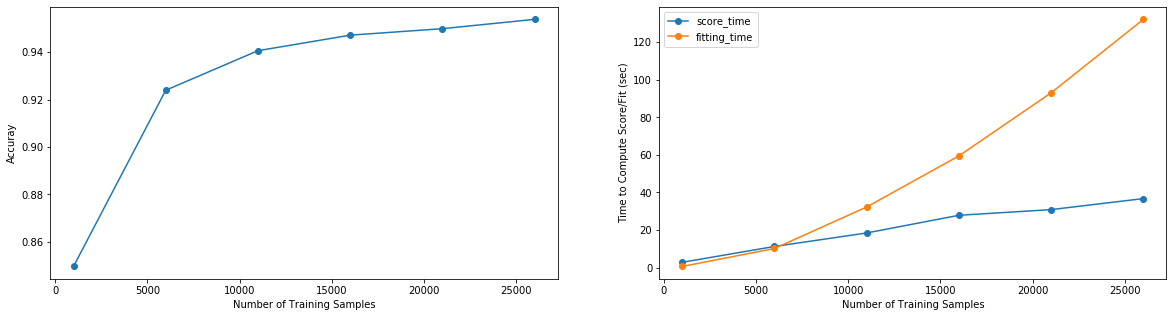

In [23]:
x=list(range(1000,31000,5000))
plt.figure(figsize=[20,5]);
ax1=plt.subplot(1, 2,1)
ax1.plot(x,score,'-o');
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuray')
ax2=plt.subplot(1, 2,2)
ax2.plot(x,score_time,'-o');
ax2.plot(x,fit_time,'-o');
plt.xlabel('Number of Training Samples')
plt.ylabel('Time to Compute Score/Fit (sec)')
plt.legend(['score_time','fitting_time'])

## <a id="param"> 5. Parameter Selection for SVM using GridSearchCV</a>

Out of parameters below, we will be playing with **Gamma** and **C**, where<br> 
    <br>[Gamma](https://www.quora.com/What-are-C-and-gamma-with-regards-to-a-support-vector-machine) is the parameter of a Gaussian Kernel (to handle non-linear classification)<br>
    and **C** the parameter for the soft margin cost function, also known as cost of misclassification. A large C gives you low bias and high variance and vice versa.

In [24]:
clf.get_params

<bound method BaseEstimator.get_params of SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)>

To find optimal combination of parameters to achieve maximum accuracy ,using **GridSearchCV** from **sklearn** library. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) does exhaustive search over specified parameter values for an estimator. <br>
Storing values of parameters to be passed to GridSearch in **parameters**, keeping cross-validation folds as **3** and passing SVM as estimator. 

In [25]:
parameters = {'gamma': [1, 0.1, 0.01, 0.001],
             'C': [1000, 100, 10, 1]} 

p = GridSearchCV(clf , param_grid=parameters, cv=3)

For Case 4 (Binary Images and PCA Reduction):

In [26]:
X=train_pca_b[:i]
y=train_labels[:i].values.ravel()
start_time = time.time()
p.fit(X,y)
elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Time consumed to fit model:  00:07:35


In [27]:
print("Scores for all Parameter Combination: \n",p.cv_results_['mean_test_score'])
print("\nOptimal C and Gamma Combination: ",p.best_params_)
print("\nMaximum Accuracy acheieved on LeftOut Data: ",p.best_score_)

Scores for all Parameter Combination: 
 [0.113  0.1816 0.7796 0.9298 0.113  0.1816 0.7796 0.9298 0.113  0.1816
 0.7796 0.931  0.1122 0.1756 0.7632 0.92  ]

Optimal C and Gamma Combination:  {'C': 10, 'gamma': 0.001}

Maximum Accuracy acheieved on LeftOut Data:  0.931


To verify, lets pass the optimal parameters to Classifier and check the score.

In [28]:
C=p.best_params_['C']
gamma=p.best_params_['gamma']
clf=svm.SVC(C=C,gamma=gamma, random_state=42)

In [29]:
start_time = time.time()
clf.fit(train_pca_b[:i], train_labels[:i].values.ravel())
elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print("Accuracy for binary: ",clf.score(test_pca_b,test_labels))

Time consumed to fit model:  00:00:03
Accuracy for binary:  0.9370238095238095


It can be seen that for the chosen training samples, accuracy of Case 2 has increased from (~91%) to (94%) for the optimal parameters.<br>
Now using all training samples

In [30]:
start_time = time.time()
clf.fit(train_pca_b, train_labels.values.ravel())
elapsed_time = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
print("Accuracy for binary: ",clf.score(test_pca_b,test_labels))

Time consumed to fit model:  00:01:29
Accuracy for binary:  0.9689285714285715


## <a id="sub"> 6. Submission</a>

Using all data from train and test files for Submission.
Following Case4 for submission, which involves conversion of images to binary followed by dimensionality reduction.

In [31]:
train_data = data #read and label removed in initial steps
train_label=label
test_data = pd.read_csv('./data/test.csv')

Converting Images to binary

In [32]:
train_data[train_data>0]=1
test_data[test_data>0]=1

Reducing Dimensions using PCA

Text(0, 0.5, 'Variance')

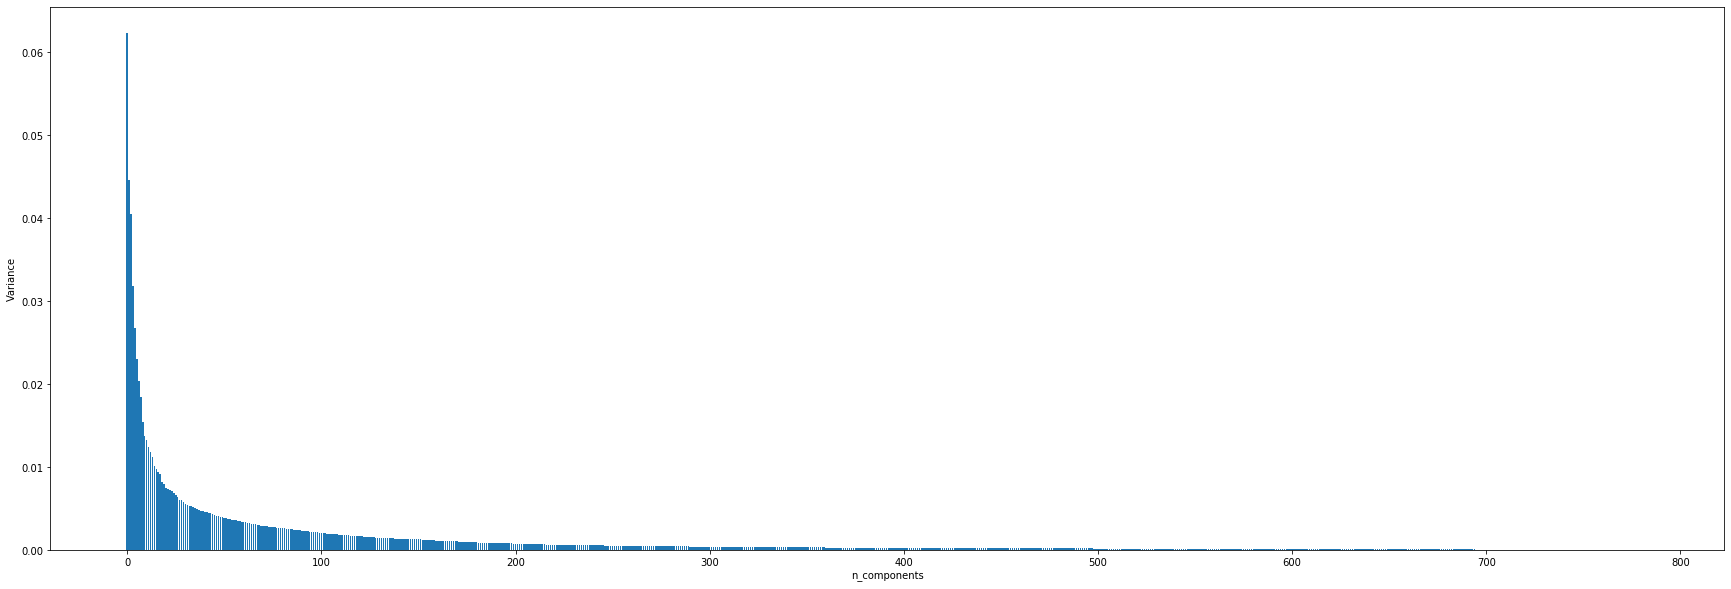

In [33]:
#standardize data
sc = StandardScaler().fit(train_data)
X_std_train = sc.transform(train_data)
X_std_test = sc.transform(test_data)

#If n_components is not set then all components are stored 
sklearn_pca = sklearnPCA().fit(X_std_train)

#Percentage of variance explained by each of the selected components.
#If n_components is not set then all components are stored and the sum of the ratios is equal to 1.0.
var_per = sklearn_pca.explained_variance_ratio_
cum_var_per = sklearn_pca.explained_variance_ratio_.cumsum()

plt.figure(figsize=(30,10))
ind = np.arange(len(var_per)) 
plt.bar(ind,var_per)
plt.xlabel('n_components')
plt.ylabel('Variance')

In [34]:
n_comp=len(cum_var_per[cum_var_per <= 0.90])
print("Keeping 90% Info with ",n_comp," components")
sklearn_pca = sklearnPCA(n_components=n_comp)
train_pca_b = sklearn_pca.fit_transform(X_std_train)
test_pca_b = sklearn_pca.transform(X_std_test)
print("Shape before PCA for Train: ",X_std_train.shape)
print("Shape after PCA for Train: ",train_pca_b.shape)
print("Shape before PCA for Test: ",X_std_test.shape)
print("Shape after PCA for Test: ",test_pca_b.shape)

Keeping 90% Info with  293  components
Shape before PCA for Train:  (42000, 784)
Shape after PCA for Train:  (42000, 293)
Shape before PCA for Test:  (28000, 784)
Shape after PCA for Test:  (28000, 293)


Fitting Training Data

In [35]:
start_time = time.time()
clf.fit(train_pca_b, label.values.ravel())
fittime = time.time() - start_time
print("Time consumed to fit model: ",time.strftime("%H:%M:%S", time.gmtime(fittime)))

Time consumed to fit model:  00:01:59


Predicting Test Data

In [36]:
start_time = time.time()
result=clf.predict(test_pca_b)
print("Accuracy for Binary(PCA): ",result)
elapsed_time = time.time() - start_time
print("Time consumed to predict: ",time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Accuracy for Binary(PCA):  [2 0 9 ... 3 9 2]
Time consumed to predict:  00:01:51


Saving result to Output File for submission

In [37]:
data_to_submit = pd.DataFrame({
    'ImageId':test_data.index.values+1,
    'Label':result
})
data_to_submit.index=data_to_submit['ImageId'].values

data_to_submit.to_csv('svm_result.csv', index = False)


I'm writng these notebooks as a part of my learning and to give back to community, would love to hear if I have missed something, or if you have any suggestions. Thanks. 